In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from keras.optimizers import *
from sklearn.decomposition import PCA
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, validation_curve, GridSearchCV, ShuffleSplit, learning_curve
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, classification_report
from sklearn.svm import SVC
import seaborn as sns
from sklearn.multiclass import OneVsRestClassifier
import joblib
from sklearn.pipeline import Pipeline

# READ DATASET

In [2]:
df = pd.read_csv('C:/Users/norma/Desktop/BİTİRME/BITIRME/Without_MCI_GSE_OrtakData_NormR.csv', sep = ";", decimal=",")
# Keeping only 2 classes which are AD and CTL
df = df[df.Class != 2]

In [3]:
features = df.drop('Class',axis=1)
labels_dr = 'C:/Users/norma/Desktop/BİTİRME/BITIRME/OneHotEncoded_Labels.csv'
labels_df = pd.read_csv(labels_dr, sep = ',')
labels = labels_df.iloc[:949,:2]

# PCA

In [4]:
n_components = 225
pca = PCA(n_components = n_components).fit(features)
principalComponents = pca.fit_transform(features)
columns = ['Pc' + str(i) for i in range(1,n_components+1)]
principalDf = pd.DataFrame(data = principalComponents
             , columns = columns)

In [5]:
x_train, x_test, y_train, y_test = train_test_split(principalDf, labels, test_size = 0.22, random_state=41)

# SELECT OPTIMAL PARAMETERS WITH GRIDSEARCHCV

In [6]:
clf = OneVsRestClassifier(SVC())

# defining parameter range
param_grid = {"estimator__C": [0.1, 1, 10, 100, 1000, 10000],
               "estimator__gamma": [1, 0.1, 0.01, 0.001, 0.0001, 0.00001],
               "estimator__kernel": ['rbf', 'poly', 'sigmoid'],
               "estimator__degree":[1, 2, 3, 4]
             }
 
grid = GridSearchCV(clf, param_grid, refit = True, verbose = 1)

grid.fit(x_train,y_train)
y_pred = grid.predict(x_test)
print(classification_report(y_test, y_pred))


Fitting 5 folds for each of 432 candidates, totalling 2160 fits
              precision    recall  f1-score   support

           0       0.65      0.78      0.71        87
           1       0.82      0.70      0.75       122

   micro avg       0.73      0.73      0.73       209
   macro avg       0.73      0.74      0.73       209
weighted avg       0.75      0.73      0.73       209
 samples avg       0.73      0.73      0.73       209



In [7]:
# print best parameter after tuning
print(grid.best_params_)

# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)

grid.best_score_

{'estimator__C': 1000, 'estimator__degree': 1, 'estimator__gamma': 0.001, 'estimator__kernel': 'sigmoid'}
OneVsRestClassifier(estimator=SVC(C=1000, degree=1, gamma=0.001,
                                  kernel='sigmoid'))


0.7243243243243243

In [8]:
class_d = 'C:/Users/norma/Desktop/BİTİRME/BITIRME/LabelEncoded_GSE_OrtakData_NormR.csv'
class_df = pd.read_csv(class_d, sep = ';', decimal = ',')
class_df = class_df[class_df.Class != 2]

#creating instance of one-hot-encoder
encoder = OneHotEncoder(handle_unknown='ignore')

encoder_df = pd.DataFrame(encoder.fit_transform(class_df[['Class']]).toarray())
encoder_df.columns = ['AD','CTL']

y_test_ = encoder.inverse_transform(y_test).ravel()

# The Optimal SVM Model

In [9]:
optimal_svm = Pipeline([ ('clf', OneVsRestClassifier(estimator=SVC(C=1000, degree=1, gamma=0.001, kernel='sigmoid'))) ])

optimal_svm.fit(x_train, y_train)

y_pred = optimal_svm.predict(x_test)

y_pred_ = np.argmax(y_pred, axis=1)

# Confusion Matrix

Classification report : 
               precision    recall  f1-score   support

           0       0.65      0.78      0.71        87
           1       0.82      0.70      0.75       122

    accuracy                           0.73       209
   macro avg       0.73      0.74      0.73       209
weighted avg       0.75      0.73      0.73       209



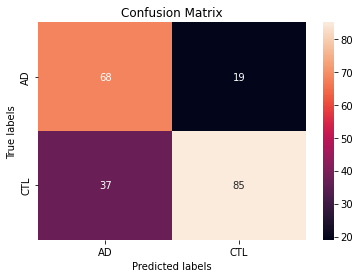

In [10]:
# classification report for precision, recall f1-score and accuracy
matrix = classification_report(y_test_, y_pred_, labels=[0,1])
print('Classification report : \n',matrix)

labels_ = ['AD','CTL']
ax= plt.subplot()

# confusion matrix
matrix = confusion_matrix(
    y_test_, y_pred_)

sns.heatmap(matrix, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels_);

# AUC-ROC

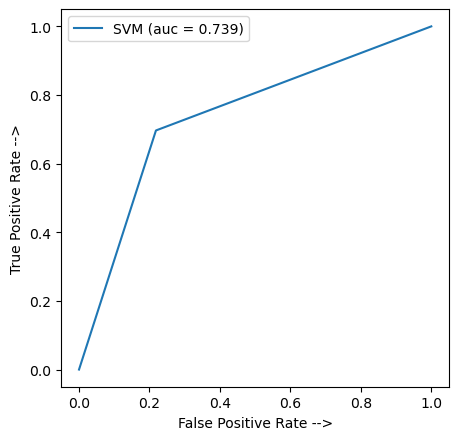

In [11]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, threshold = roc_curve(y_test_, y_pred[:,1])
auc_svm = auc(fpr,tpr)

plt.figure(figsize=(5,5), dpi=100)
plt.plot(fpr, tpr, linestyle = '-', label = 'SVM (auc = %0.3f)' % auc_svm)

plt.xlabel('False Positive Rate -->')
plt.ylabel('True Positive Rate -->')
plt.legend()
plt.show()

# Save Model

In [12]:
filename = 'C:/Users/norma/Desktop/src/SVM.h5'
joblib.dump(optimal_svm, filename)

['C:/Users/norma/Desktop/src/SVM.h5']

# Load Model

In [13]:
clf_ = joblib.load(filename)
clf_.fit(x_train, y_train)
y_pred = clf_.predict(x_test)

y_pred_ = np.argmax(y_pred, axis=1)

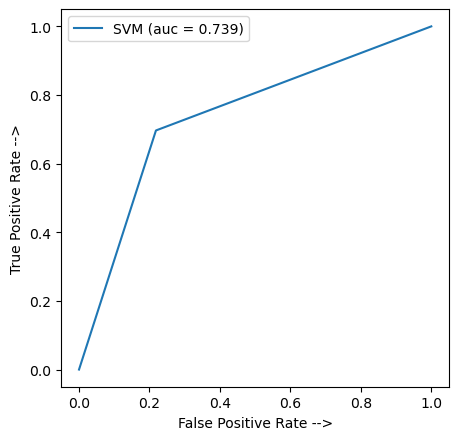

In [14]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, threshold = roc_curve(y_test_, y_pred[:,1])
auc_rf = auc(fpr,tpr)

plt.figure(figsize=(5,5), dpi=100)
plt.plot(fpr, tpr, linestyle = '-', label = 'SVM (auc = %0.3f)' % auc_rf)

plt.xlabel('False Positive Rate -->')
plt.ylabel('True Positive Rate -->')
plt.legend()
plt.show()